<a href="https://colab.research.google.com/github/emil565a/NLP/blob/main/NLP_Project_week_38Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install sklearn
!pip3 install nltk
!pip3 install transformers
!pip install transformers datasets evaluate
!pip install transformers[torch]
!pip install accelerate -U
!pip3 install transformers[torch]
!pip3 install accelerate -U
!pip3 install gensim
!pip3 install sentence-transformers
!import nltk


/bin/bash: line 1: import: command not found


In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
import string
import re

import tensorflow as tf

import transformers
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForQuestionAnswering
from transformers import DefaultDataCollator
from transformers import TFTrainer #Used for training model
from transformers import TFTrainingArguments #Used fo training arguments
from transformers import BertTokenizer, squad_convert_examples_to_features, SquadV2Processor
from transformers.data.processors.squad import SquadExample
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import matutils

In [3]:
nltk.download('punkt')
dataset = load_dataset("copenlu/answerable_tydiqa")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Also load dataset as pandas.DataFrame, in case we need it later
train_pd = pd.DataFrame(data=dataset["train"])
validation_pd = pd.DataFrame(data=dataset["validation"])

In [5]:
arabic_train = train_pd[train_pd['language'] == 'arabic']
bengali_train = train_pd[train_pd['language'] == 'bengali']
indo_train = train_pd[train_pd['language'] == 'indonesian']

arabic_validation = validation_pd[validation_pd['language'] == 'arabic']
bengali_validation = validation_pd[validation_pd['language'] == 'bengali']
indo_validation = validation_pd[validation_pd['language'] == 'indonesian']

In [6]:
#print columns
print(arabic_train.columns)

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url'],
      dtype='object')


In [7]:
def tokenizerOld(text):
  #Tokenize the text and translate
  tokens = [word.lower() for word in nltk.word_tokenize(text)]
  return tokens

#New that utilize transformer.AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True)

class entry:
    def __init__(self, question_text, document_title, language, annotations, document_plaintext, document_url):
        self.question_text = question_text
        self.document_title = document_title
        self.language = language
        self.annotations = annotations
        self.answerable = annotations.get("answer_start", [-1]) != [-1]
        self.document_plaintext = document_plaintext
        self.document_url = document_url
        self.question_tokenized = tokenizerOld(self.question_text)
        self.document_tokenized = tokenizerOld(self.document_plaintext)

        #To use with the transformer library
        self.answers = {'answer_start': annotations['answer_start'], 'text': annotations['answer_text']}
        self.context = document_plaintext
        self.id = document_url
        self.question = question_text
        self.title = document_title


    def __str__(self):
        return f"Question: {self.question_text}\n" \
               f"Document Title: {self.document_title}\n" \
               f"Language: {self.language}\n" \
               f"Annotations: {self.annotations}\n" \
               f"Document Plaintext: {self.document_plaintext}\n" \
               f"Document URL: {self.document_url}\n" \
               f"Answerable: {self.answerable}"\
               f"Question Tokenized: {self.question_tokenized}\n" \
               f"Document Tokenized: {self.document_tokenized}"

arabic_train_entries = []
for index,row in arabic_train.iterrows():
    arabic_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

arabic_validation_entries = []
for index,row in arabic_validation.iterrows():
    arabic_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))


bengali_train_entries = []
for index,row in bengali_train.iterrows():
    bengali_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

bengali_validation_entries = []
for index,row in bengali_validation.iterrows():
    bengali_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

indo_train_entries = []
for index,row in indo_train.iterrows():
    indo_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))
indo_validation_entries = []
for index,row in indo_validation.iterrows():
    indo_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))



# Simple classifier (Well in terms of lines of code)

In [8]:
pipelineModel = pipeline("question-answering", model="timpal0l/mdeberta-v3-base-squad2")


# Emils Supervised Classifier

### Preproccesing


In [9]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question_text"]]
    inputs = tokenizer(
        questions,
        examples["document_plaintext"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["annotations"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["answer_text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

### tokenize the data

In [ ]:
#tokenizerArabic  = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

#https://huggingface.co/arabi-elidrisi/ArabicDistilBERT_QA
arabic_dataset = dataset.filter(lambda example: example['language'] == 'arabic')
arabic_tokenizer = AutoTokenizer.from_pretrained("arabi-elidrisi/ArabicDistilBERT_QA")
arabic_tokenized_squad = arabic_dataset.map(preprocess_function, batched=True, remove_columns=arabic_dataset["train"].column_names)
arabic_model = AutoModelForQuestionAnswering.from_pretrained("arabi-elidrisi/ArabicDistilBERT_QA")

#https://huggingface.co/sagorsarker/mbert-bengali-tydiqa-qa
bengali_dataset = dataset.filter(lambda example: example['language'] == 'bengali')
bengali_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/mbert-bengali-tydiqa-qa")
bengali_tokenized_squad = bengali_dataset.map(preprocess_function, batched=True, remove_columns=bengali_dataset["train"].column_names)
bengali_model = AutoModelForQuestionAnswering.from_pretrained("sagorsarker/mbert-bengali-tydiqa-qa")

#https://huggingface.co/Rifky/Indobert-QA
indo_dataset = dataset.filter(lambda example: example['language'] == 'indonesian')
indo_tokenizer = AutoTokenizer.from_pretrained("Rifky/Indobert-QA")
indo_tokenized_squad = indo_dataset.map(preprocess_function, batched=True, remove_columns=indo_dataset["train"].column_names)
indo_model = AutoModelForQuestionAnswering.from_pretrained("Rifky/Indobert-QA")

Map:   0%|          | 0/29598 [00:00<?, ? examples/s]

In [ ]:
data_collator = DefaultDataCollator()

### Training the model

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=32e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.00001,
)

arabic_trainer = Trainer(
    model=arabic_model,
    args=training_args,
    train_dataset=arabic_tokenized_squad["train"],
    eval_dataset=arabic_tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

arabic_trainer.train()




# Chris' Supervised Classifier

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Get encoding model from SentenceTransformer package
# Derived from here: https://huggingface.co/intfloat/multilingual-e5-base
model = SentenceTransformer("intfloat/multilingual-e5-base")

def train_SGD_classifier(training_data, validation_data, language):
    # Encode documents and questions to create inputs of size=768
    train_document_e = model.encode([x for x in training_data["document_plaintext"]])
    train_question_e = model.encode([x for x in training_data["question_text"]])
    valid_document_e = model.encode([x for x in validation_data["document_plaintext"]])
    valid_question_e = model.encode([x for x in validation_data["question_text"]])

    # Collect labels (true outputs) for each pair
    train_labels = [1 if x["answer_start"] != [-1] else 0 for x in training_data["annotations"]]
    valid_labels = [1 if x["answer_start"] != [-1] else 0 for x in validation_data["annotations"]]

    # Concatenate "document encoding" and "question encoding" to create combined inputs of size=1536
    train_combined_e = [np.concatenate((x[0], x[1]), axis=0) for x in zip(train_document_e, train_question_e)]
    valid_combined_e = [np.concatenate((x[0], x[1]), axis=0) for x in zip(valid_document_e, valid_question_e)]

    # Train SGD Classifier instance
    classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    classifier.fit(train_combined_e, train_labels)

    # Determine classifier accuracy based on true/predicted scores
    outputs = classifier.predict(valid_combined_e)
    print("Accuracy score (" + language + "): " + str(accuracy_score(valid_labels, outputs)))

# Test SGD Classifier for each input language
for train, valid, lang in [(arabic_train, arabic_validation, "arabic"),
                           (bengali_train, bengali_validation, "bengali"),
                           (indo_train, indo_validation, "indonesian")]:
    train_SGD_classifier(train, valid, lang)

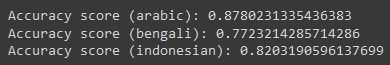

# Model 3

In [ ]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#Preprocessing
def textPreprocessing(text):
    text = text.lower() #lower case
    #tokenization
    tokens = word_tokenize(text)
    #remove stop words
    stop_words = set(stopwords.words('english'))
    #Remove punctuation
    stop_words.update(string.punctuation)
    filteredTokens = [w for w in tokens if not w in stop_words]
    #stemming
    ps = PorterStemmer()
    stemmedTokens = [ps.stem(w) for w in filteredTokens]
    #lemmatization
    return stemmedTokens

#TF-IDF
def textTo_TFIDF(processedTexts):
    dictionary = corpora.Dictionary(processedTexts)
    #doc2bow = bag of words. list of tuples (word_id, word_frequency)
    corpus = [dictionary.doc2bow(text,allow_update=True) for text in processedTexts]

    #tfidModel:
    model = models.TfidfModel(corpus)
    #tfidfModel[corpus[0]]: tfidf vector for the first document
    tfidf = model[corpus]
    return dictionary, corpus, tfidf

In [ ]:
processedOverviews = [movieObject.processedOverview for movieObject in movieObjects]
vocab = corpora.Dictionary(processedOverviews)
vobabSize = len(vocab)

#Setting the TF-IDF vector for each movie object
for i in range(len(movieObjects)):
    movieObjects[i].TF_IDF = TF_IDF_vectors[i]